In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [2]:
train_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5p\\train"
test_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5p\\test"
val_path = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5p\\val"

path1 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5p\\annotationleopard.csv"
path2 = "C:\\Users\\kssol\\PycharmProjects\\pp_lab5p\\annotationtiger.csv"
dfs = []
tmp = pd.read_csv(path1, sep=',', header=None, encoding='UTF-16') 
dfs.append(tmp)
tmp = pd.read_csv(path2, sep=',', header=None, encoding='UTF-16')
dfs.append(tmp)
df = pd.concat(dfs)
df.drop(1, axis=1, inplace=True)
df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)


In [4]:
def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    """loads images from the dataframe along the selected path"""
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)



for i in range(168):
    load_train(df, train_path, i)
for i in range(661, 783):
    load_train(df, train_path, i)
for i in range(168, 595):
    load_test(df,test_path,i)
for i in range(783, 595):
    load_test(df,test_path,i)
for i in range(190,210):
    load_val(df,val_path,i)
for i in range(595,870):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
val_list = glob.glob(os.path.join(val_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)    

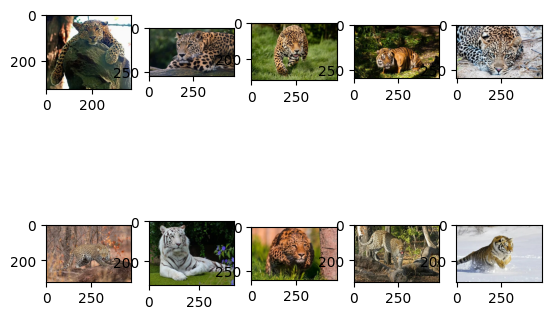

In [5]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()


In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])


In [8]:

from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'leopard':
            label = 1
        elif label == 'tiger':
            label = 0

        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)


Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.5148149132728577, train loss : 0.680964469909668
Epoch : 1, val_accuracy : 0.5777778029441833, val_loss : 0.6323763728141785
Epoch : 2, train accuracy : 0.6148147583007812, train loss : 0.6517479419708252
Epoch : 2, val_accuracy : 0.585185170173645, val_loss : 0.7024312019348145
Epoch : 3, train accuracy : 0.6629629731178284, train loss : 0.6219629049301147
Epoch : 3, val_accuracy : 0.585185170173645, val_loss : 0.5645935535430908
Epoch : 4, train accuracy : 0.6185185313224792, train loss : 0.6333446502685547
Epoch : 4, val_accuracy : 0.45185187458992004, val_loss : 0.6931657791137695
Epoch : 5, train accuracy : 0.6740739941596985, train loss : 0.5953032970428467
Epoch : 5, val_accuracy : 0.5888888835906982, val_loss : 0.6544193029403687
Epoch : 6, train accuracy : 0.6555555462837219, train loss : 0.588626503944397
Epoch : 6, val_accuracy : 0.5925925970077515, val_loss : 0.7510960102081299
Epoch : 7, train accuracy : 0.

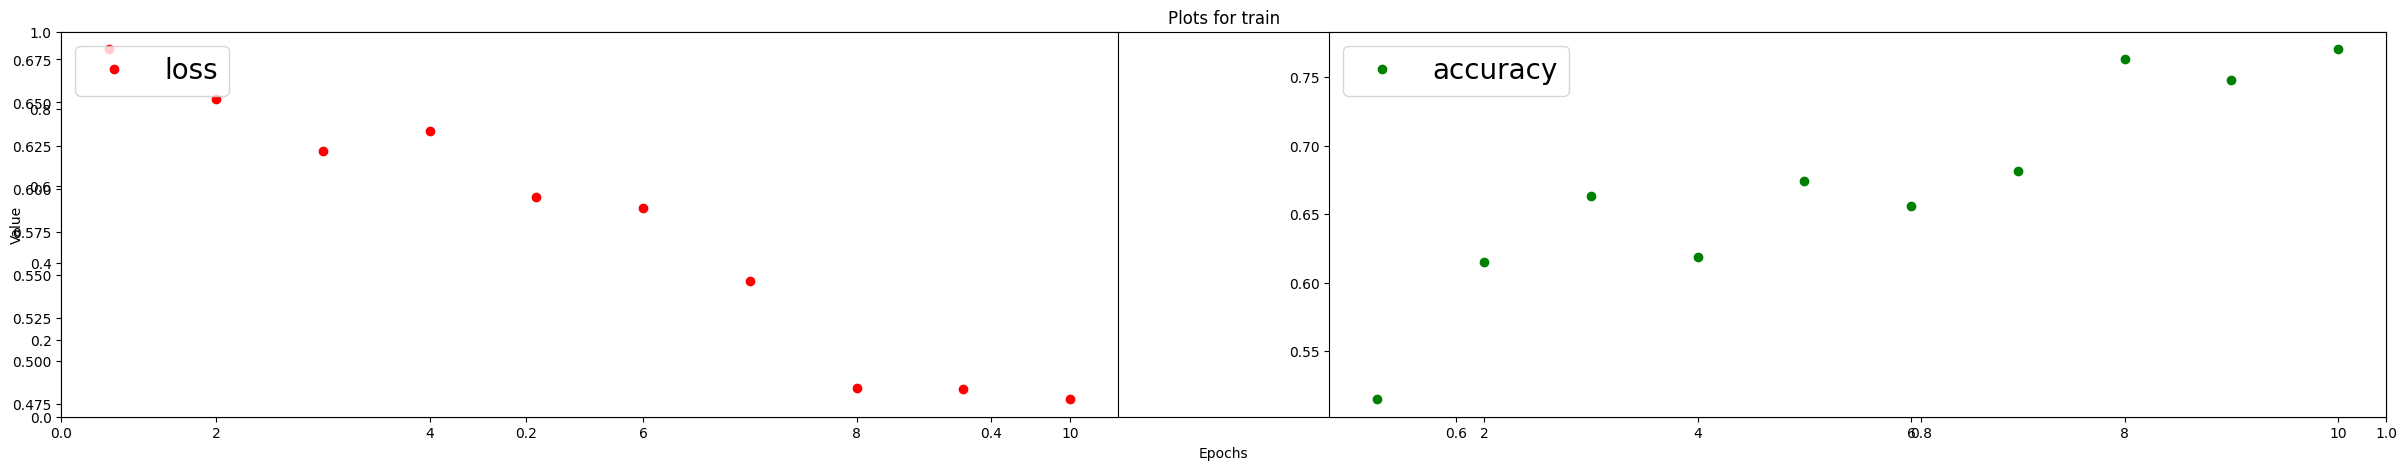

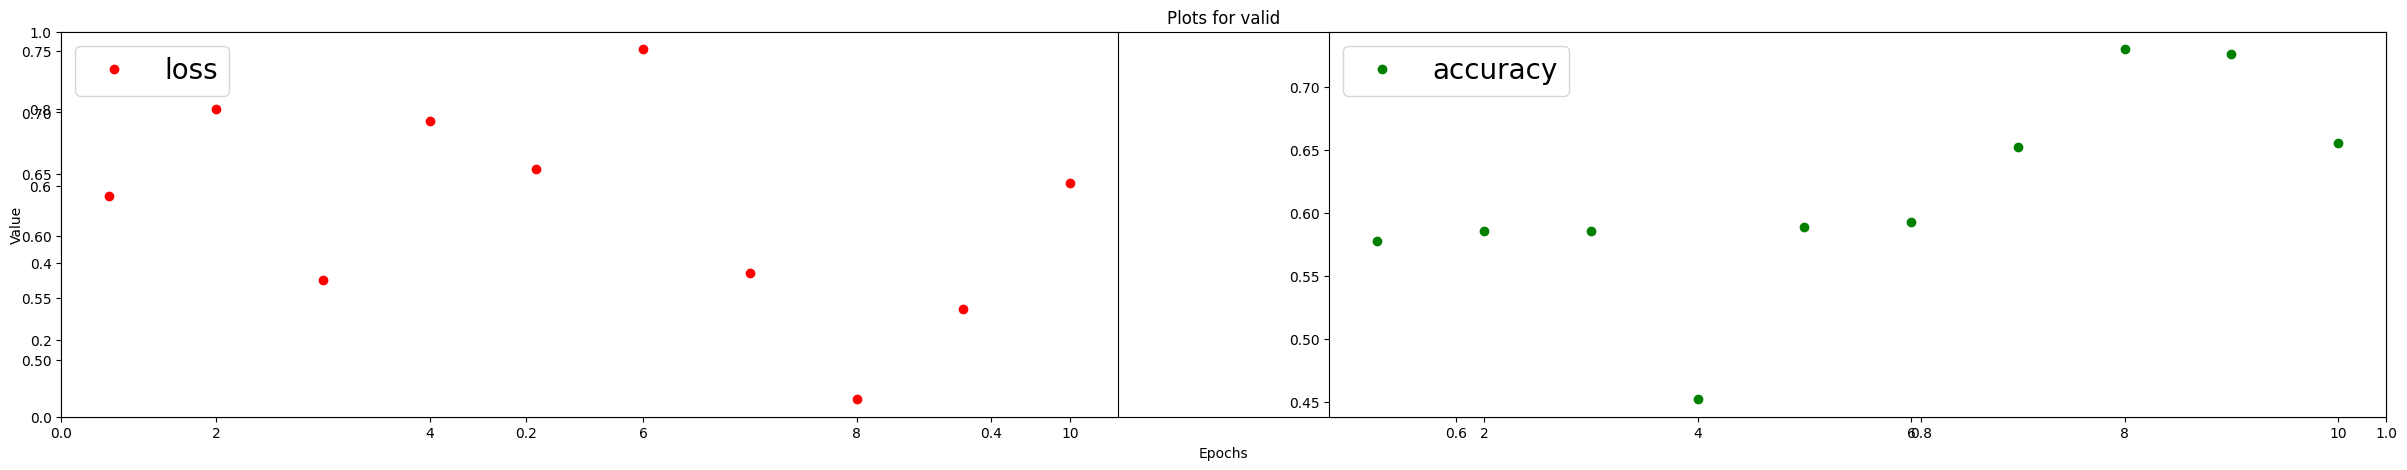

In [9]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)


            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20})
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20})

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.7518517971038818, train loss : 0.4604567587375641
Epoch : 1, val_accuracy : 0.7555555105209351, val_loss : 0.5601046085357666
Epoch : 2, train accuracy : 0.8111110925674438, train loss : 0.4245983362197876
Epoch : 2, val_accuracy : 0.7925925254821777, val_loss : 0.38324570655822754
Epoch : 3, train accuracy : 0.8444443345069885, train loss : 0.3883580267429352
Epoch : 3, val_accuracy : 0.7259259223937988, val_loss : 0.46642059087753296
Epoch : 4, train accuracy : 0.8518518209457397, train loss : 0.3565989136695862
Epoch : 4, val_accuracy : 0.6592592597007751, val_loss : 0.523410439491272
Epoch : 5, train accuracy : 0.8148148059844971, train loss : 0.4304271936416626
Epoch : 5, val_accuracy : 0.82962965965271, val_loss : 0.3899206221103668
Epoch : 6, train accuracy : 0.8555554747581482, train loss : 0.36362773180007935
Epoch : 6, val_accuracy : 0.7888888716697693, val_loss : 0.4265059232711792
Epoch : 7, train accuracy 

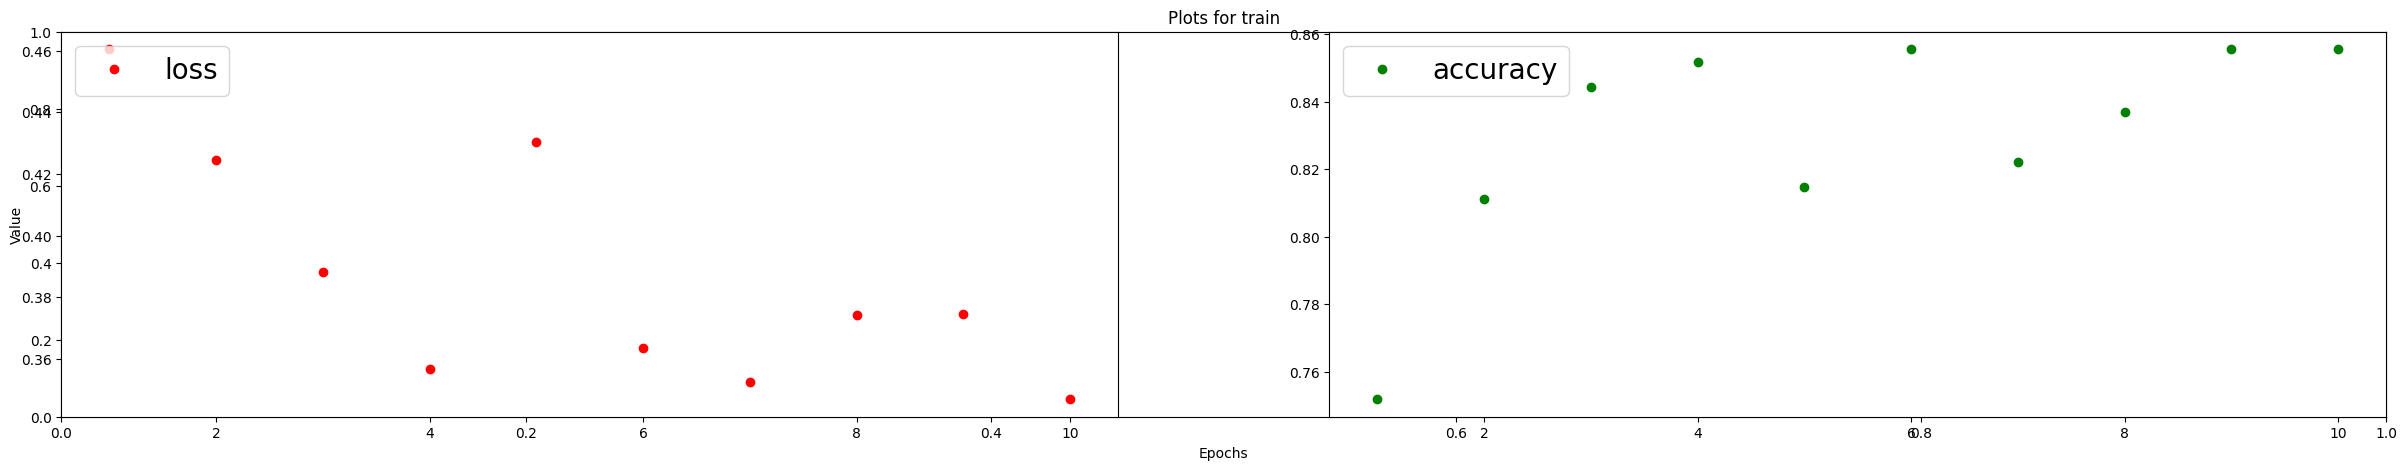

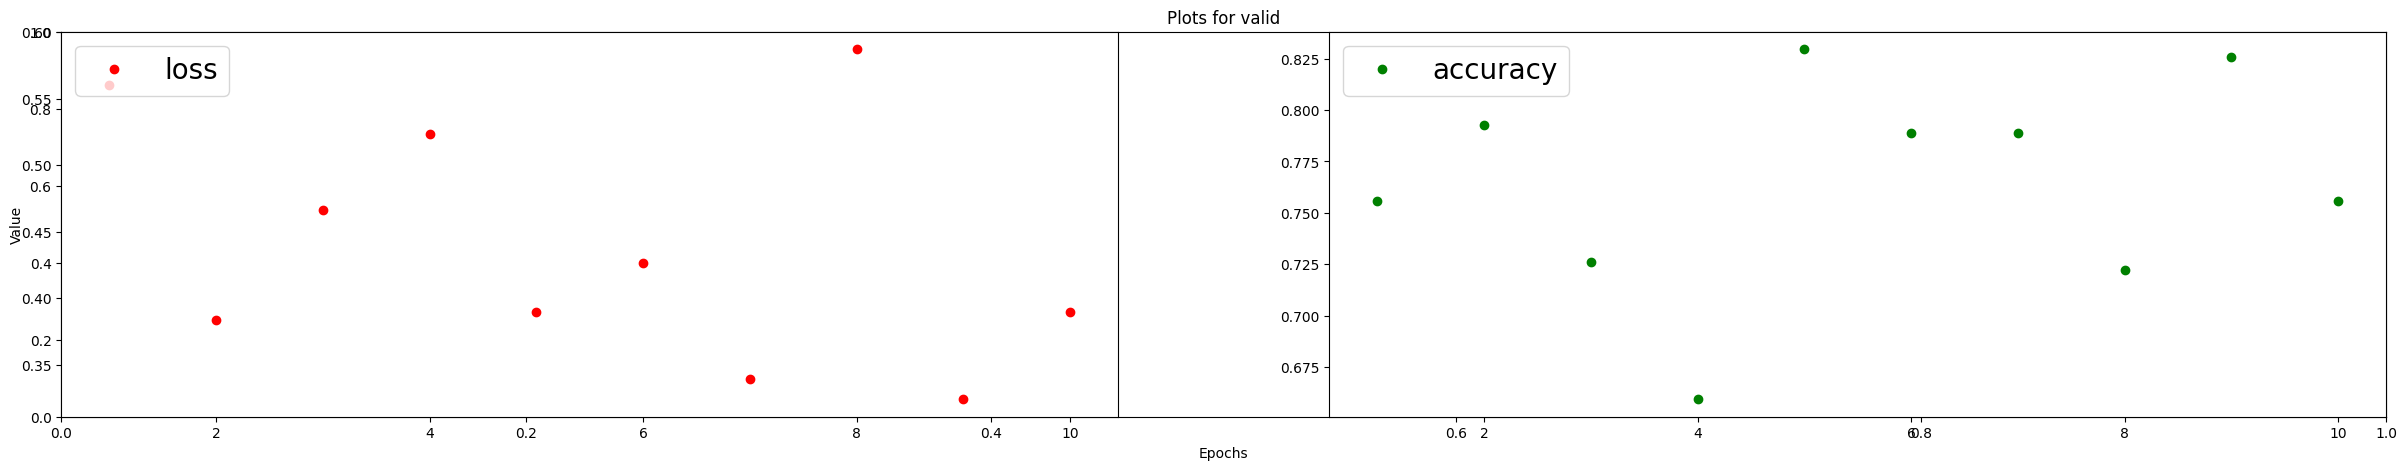

In [10]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.7481482028961182, train loss : 0.45591503381729126
Epoch : 1, val_accuracy : 0.6888889074325562, val_loss : 0.5574031472206116
Epoch : 2, train accuracy : 0.8481481075286865, train loss : 0.3421502113342285
Epoch : 2, val_accuracy : 0.7888888716697693, val_loss : 0.39381086826324463
Epoch : 3, train accuracy : 0.7925925850868225, train loss : 0.39345380663871765
Epoch : 3, val_accuracy : 0.7555555701255798, val_loss : 0.5006990432739258
Epoch : 4, train accuracy : 0.7888888120651245, train loss : 0.41680189967155457
Epoch : 4, val_accuracy : 0.7259259223937988, val_loss : 0.40939462184906006
Epoch : 5, train accuracy : 0.8592592477798462, train loss : 0.31746354699134827
Epoch : 5, val_accuracy : 0.8666666746139526, val_loss : 0.2778860032558441
Epoch : 6, train accuracy : 0.8222222328186035, train loss : 0.38035425543785095
Epoch : 6, val_accuracy : 0.7555555105209351, val_loss : 0.5026319622993469
Epoch : 7, train ac

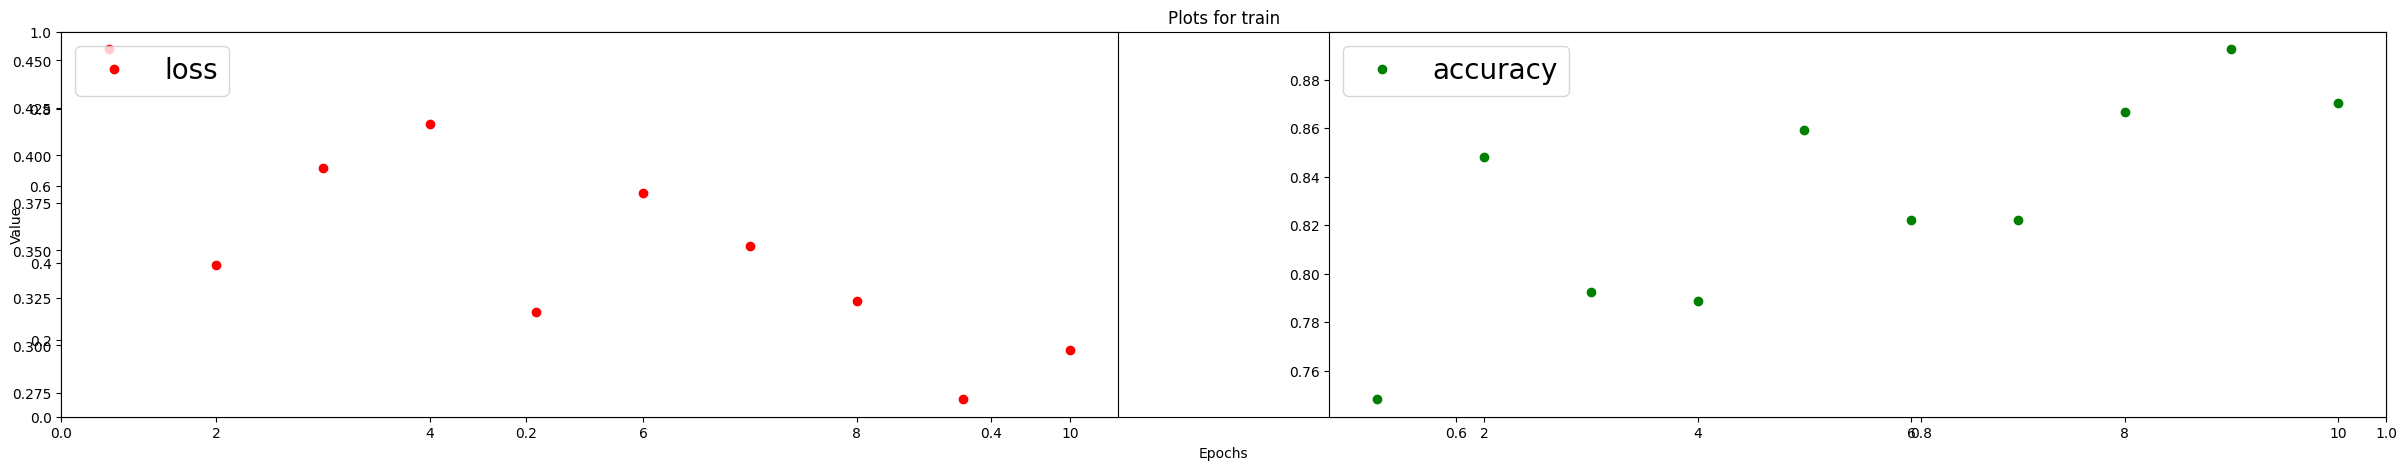

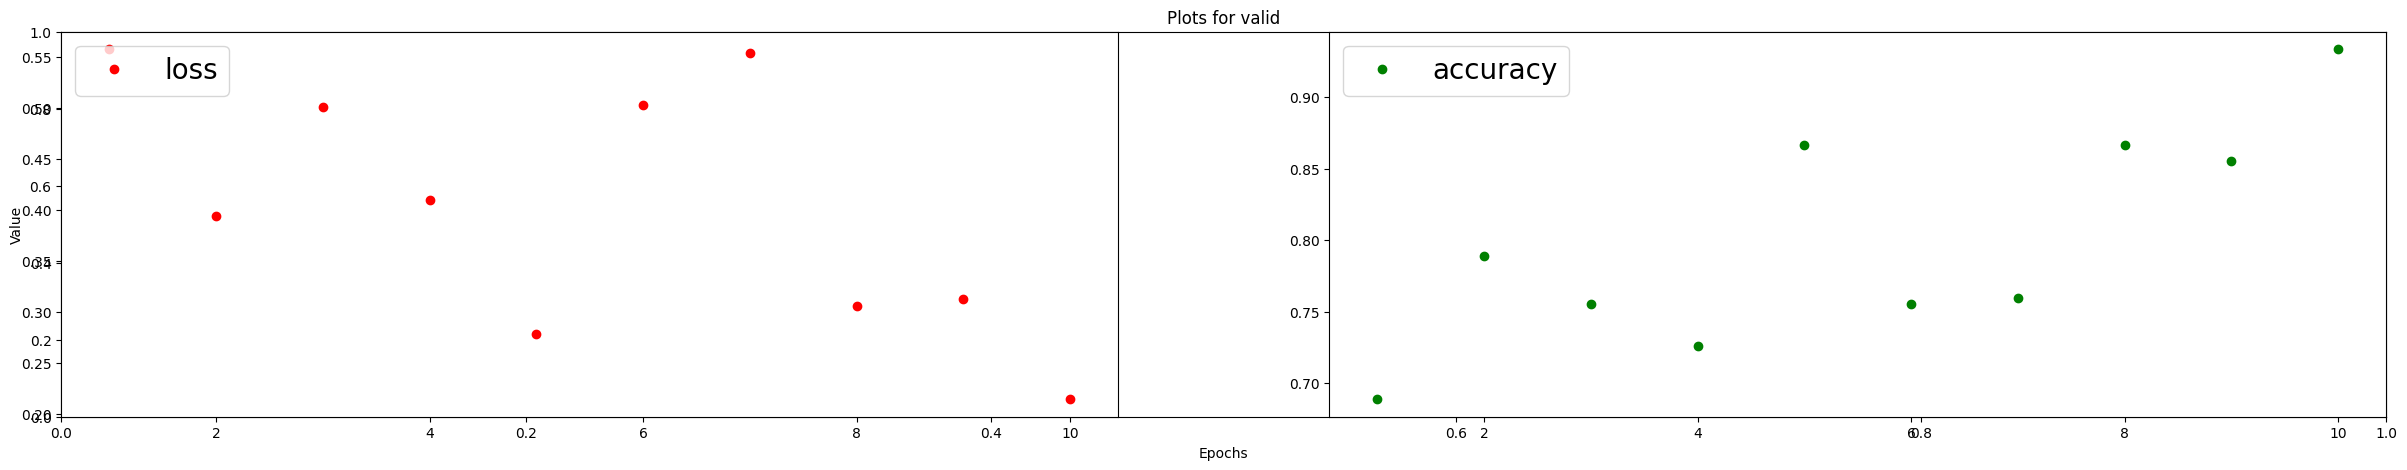

In [11]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.875, train loss : 0.3148060142993927
Epoch : 1, val_accuracy : 0.6777777671813965, val_loss : 0.5650044083595276
Epoch : 2, train accuracy : 0.9000000357627869, train loss : 0.26117634773254395
Epoch : 2, val_accuracy : 0.8694444894790649, val_loss : 0.28889375925064087
Epoch : 3, train accuracy : 0.8607142567634583, train loss : 0.2942774295806885
Epoch : 3, val_accuracy : 0.7027778029441833, val_loss : 0.44247061014175415
Epoch : 4, train accuracy : 0.8178571462631226, train loss : 0.37288400530815125
Epoch : 4, val_accuracy : 0.8444444537162781, val_loss : 0.3229633569717407
Epoch : 5, train accuracy : 0.9035714268684387, train loss : 0.257795512676239
Epoch : 5, val_accuracy : 0.6583333015441895, val_loss : 0.49435025453567505
Epoch : 6, train accuracy : 0.8428571224212646, train loss : 0.3616206645965576
Epoch : 6, val_accuracy : 0.9194444417953491, val_loss : 0.2972215414047241
Epoch : 7, train accuracy : 0.807142

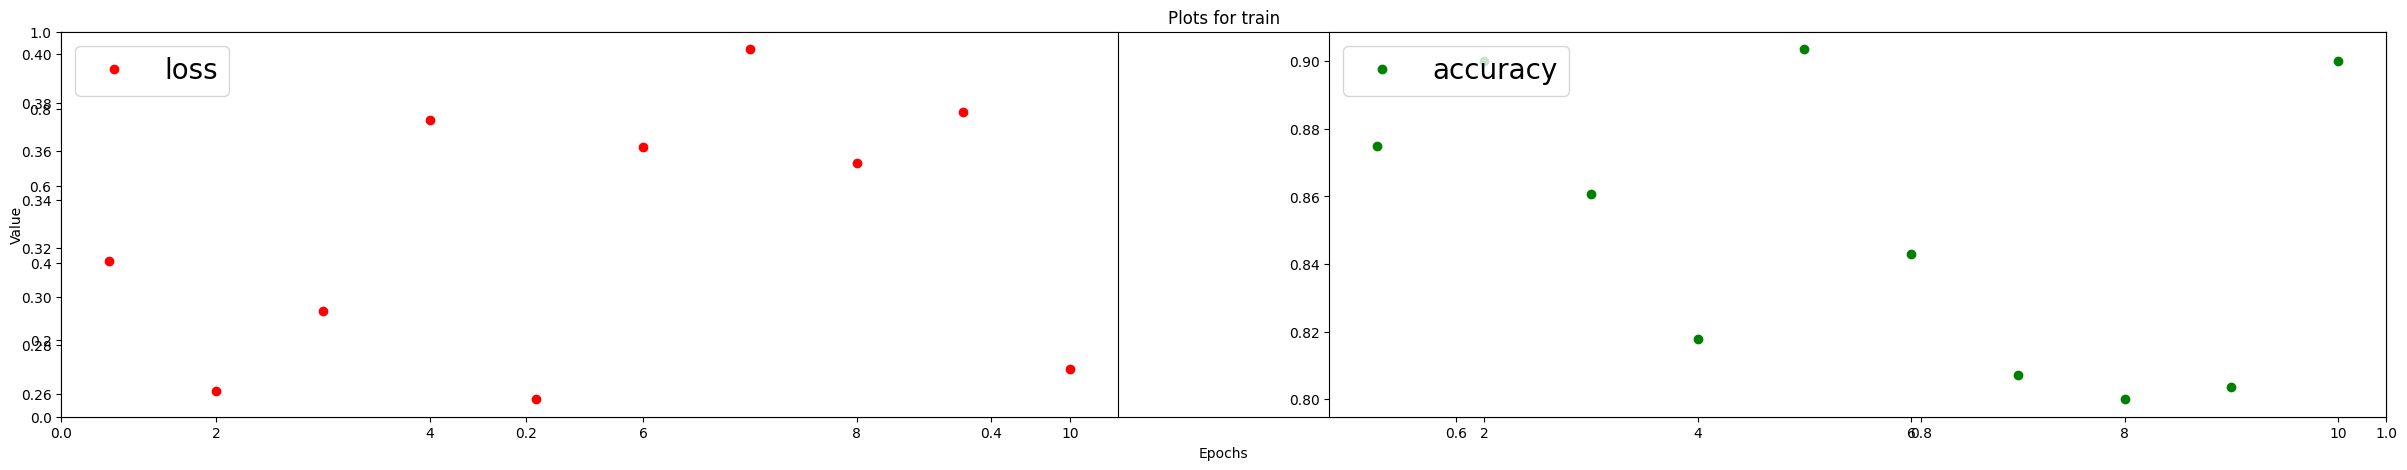

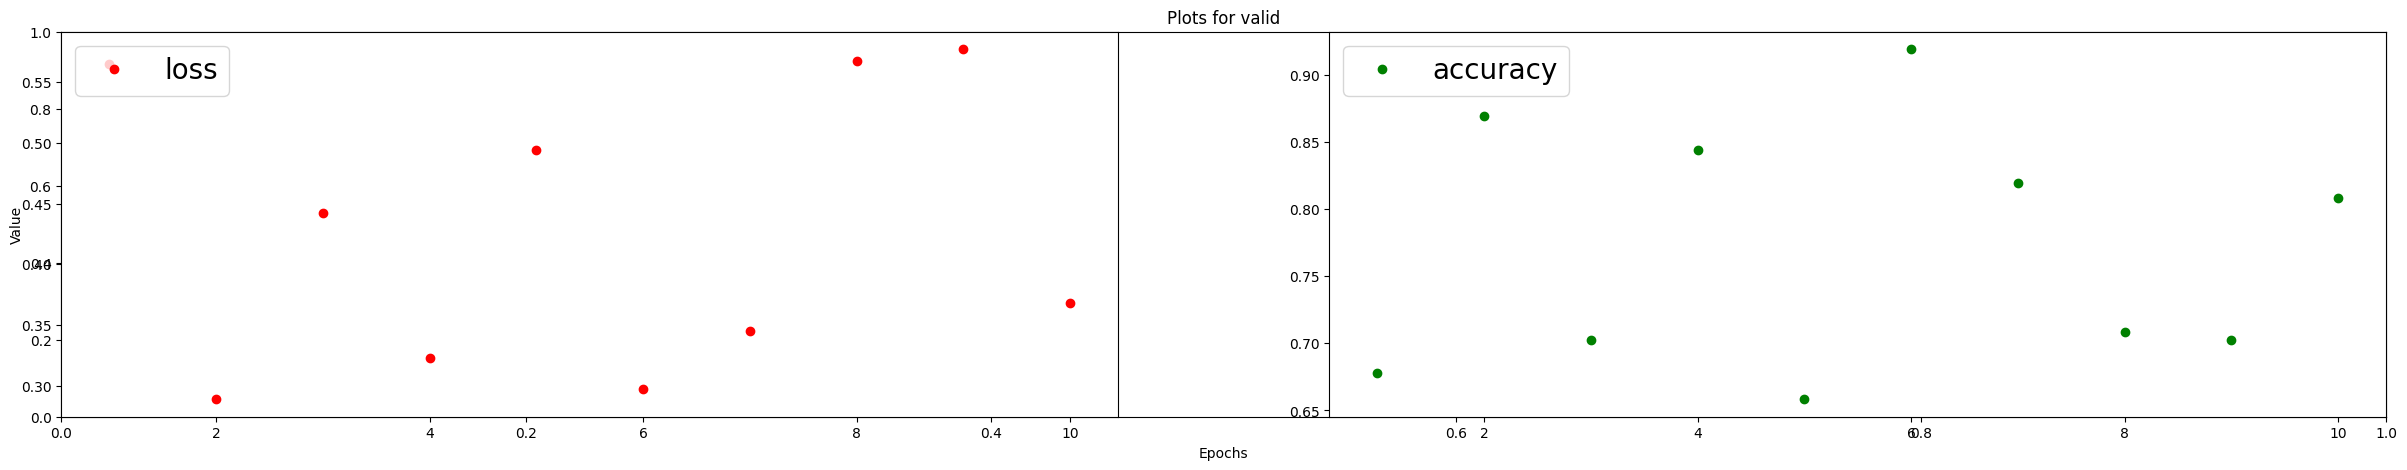

In [12]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.8928570747375488, train loss : 0.2992264926433563
Epoch : 1, val_accuracy : 0.8444444537162781, val_loss : 0.2638731002807617
Epoch : 2, train accuracy : 0.9178571105003357, train loss : 0.2209223061800003
Epoch : 2, val_accuracy : 0.894444465637207, val_loss : 0.23109975457191467
Epoch : 3, train accuracy : 0.9035714864730835, train loss : 0.22532564401626587
Epoch : 3, val_accuracy : 0.8388888835906982, val_loss : 0.31239598989486694
Epoch : 4, train accuracy : 0.8321427702903748, train loss : 0.3077391982078552
Epoch : 4, val_accuracy : 0.949999988079071, val_loss : 0.21865126490592957
Epoch : 5, train accuracy : 0.8285714387893677, train loss : 0.37500667572021484
Epoch : 5, val_accuracy : 0.8138889074325562, val_loss : 0.42302513122558594
Epoch : 6, train accuracy : 0.8392857313156128, train loss : 0.3170320689678192
Epoch : 6, val_accuracy : 0.7333333492279053, val_loss : 0.4990804195404053
Epoch : 7, train accur

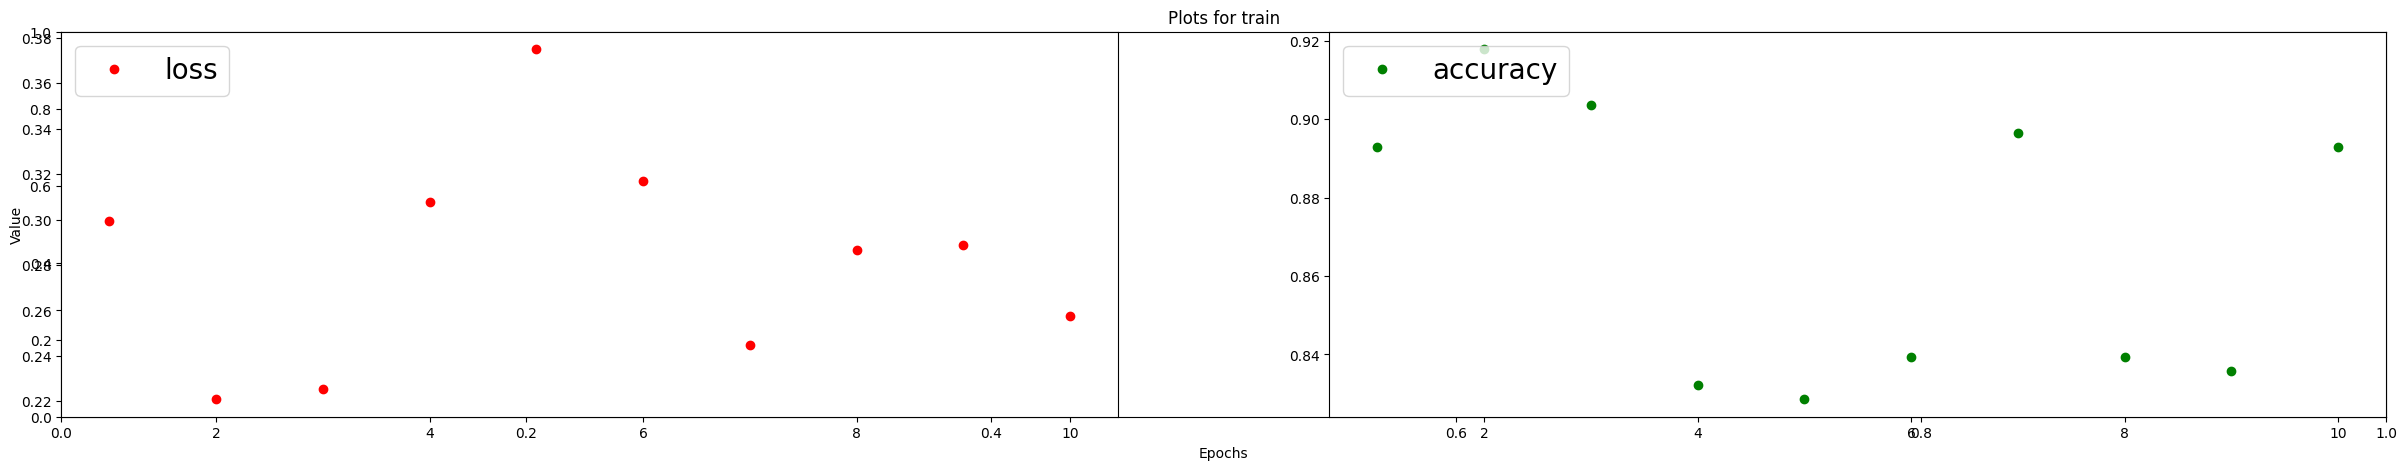

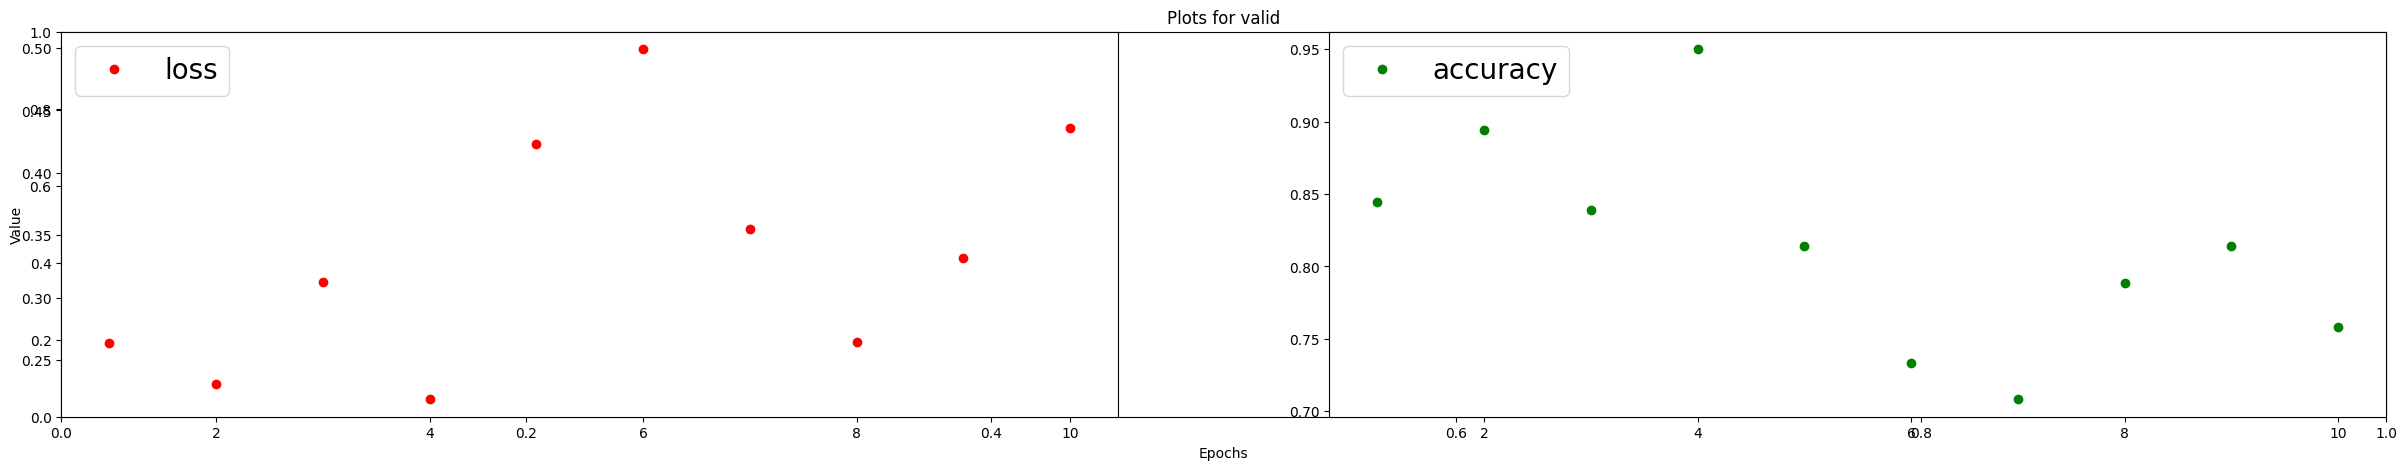

In [13]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9071428179740906, train loss : 0.2018490582704544
Epoch : 1, val_accuracy : 0.7277777791023254, val_loss : 0.49107539653778076
Epoch : 2, train accuracy : 0.8321427702903748, train loss : 0.26761937141418457
Epoch : 2, val_accuracy : 0.8388888835906982, val_loss : 0.4283254146575928
Epoch : 3, train accuracy : 0.8821427822113037, train loss : 0.279012531042099
Epoch : 3, val_accuracy : 0.8138889074325562, val_loss : 0.5562378764152527
Epoch : 4, train accuracy : 0.9464287161827087, train loss : 0.16352024674415588
Epoch : 4, val_accuracy : 0.7888889312744141, val_loss : 0.42672181129455566
Epoch : 5, train accuracy : 0.8428571820259094, train loss : 0.4135160446166992
Epoch : 5, val_accuracy : 0.7583333253860474, val_loss : 0.4486587941646576
Epoch : 6, train accuracy : 0.9321428537368774, train loss : 0.17893648147583008
Epoch : 6, val_accuracy : 0.949999988079071, val_loss : 0.19569864869117737
Epoch : 7, train accur

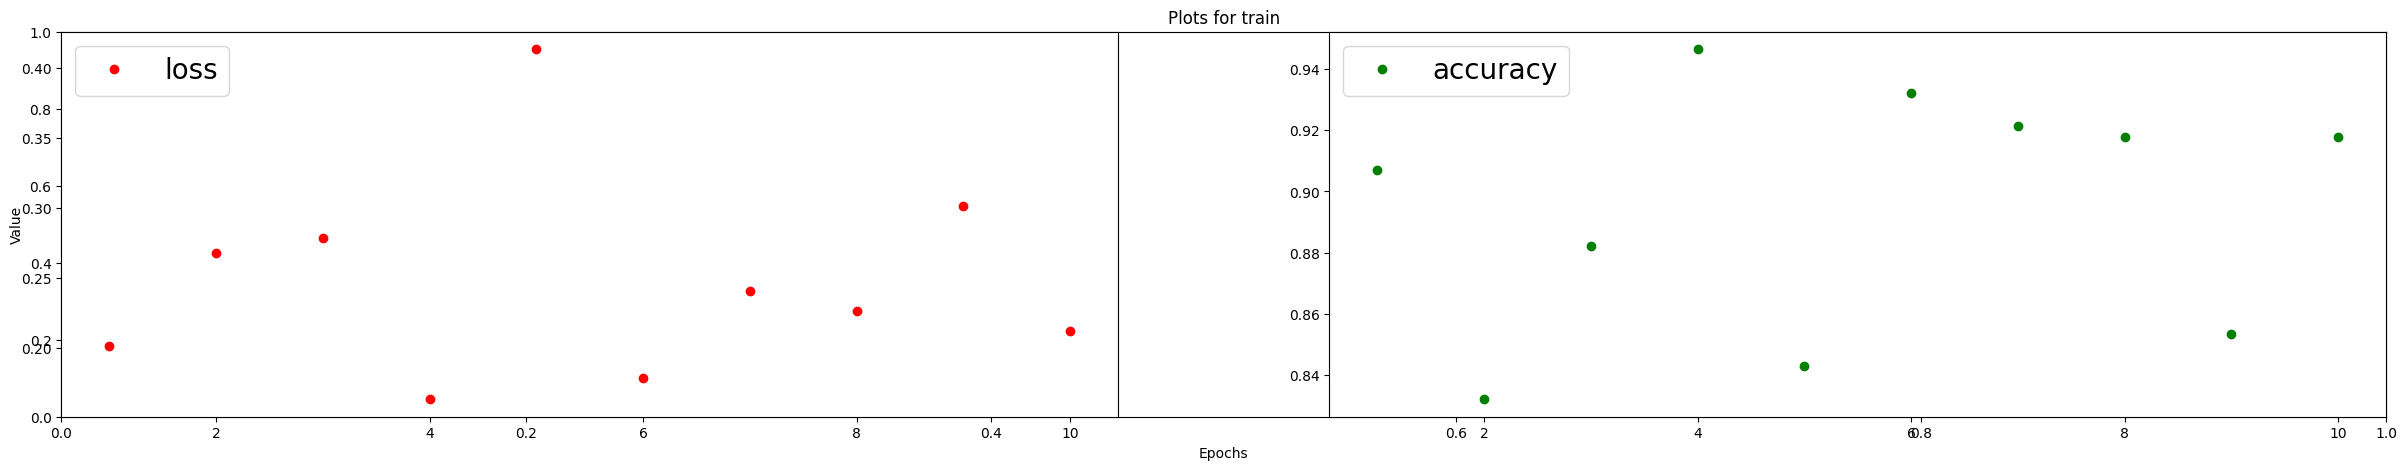

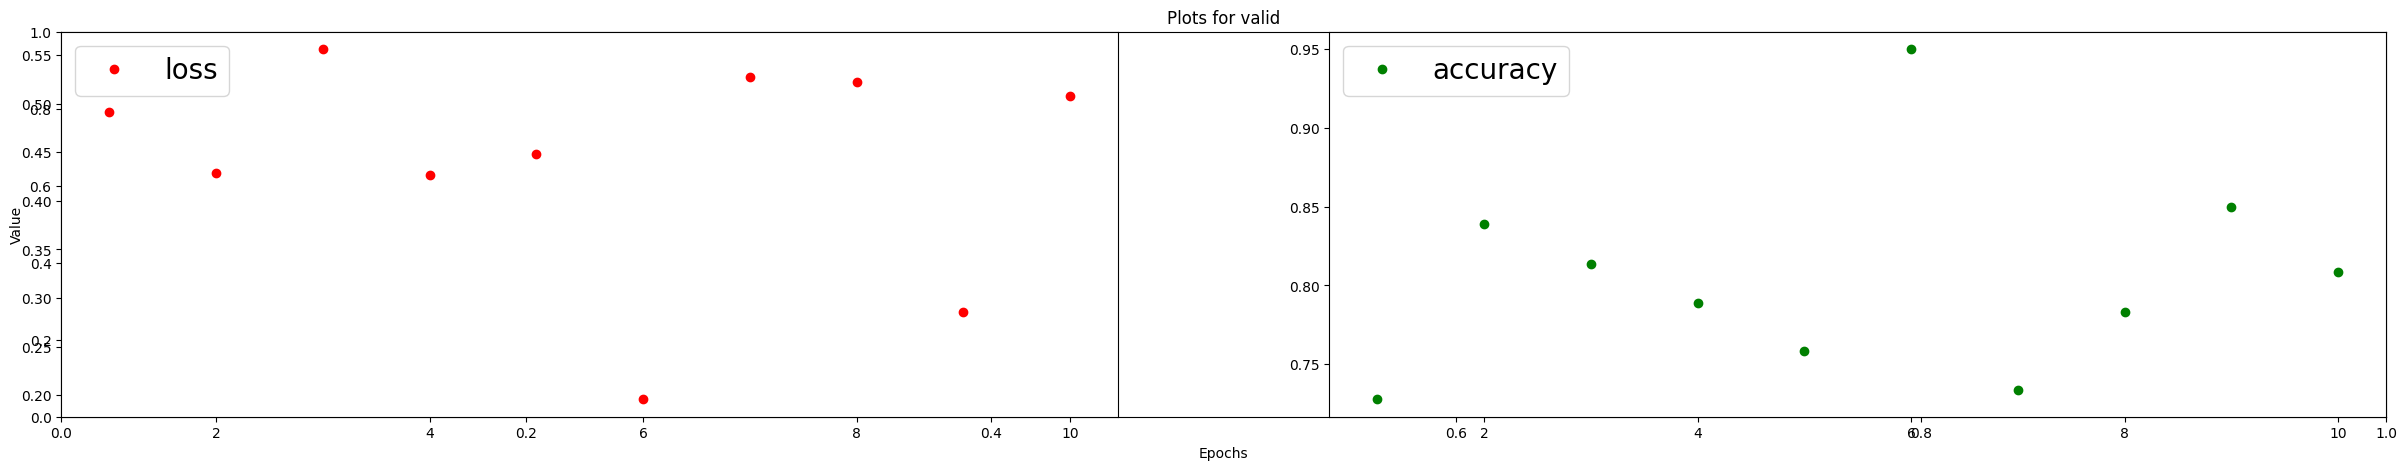

In [14]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50
Epoch : 1, train accuracy : 0.8630303144454956, train loss : 0.26122400164604187
Epoch : 1, val_accuracy : 0.8275862336158752, val_loss : 0.3210419714450836
Epoch : 2, train accuracy : 0.9300000071525574, train loss : 0.16230541467666626
Epoch : 2, val_accuracy : 0.8620689511299133, val_loss : 0.22195526957511902
Epoch : 3, train accuracy : 0.9181817770004272, train loss : 0.2063104808330536
Epoch : 3, val_accuracy : 0.8965517282485962, val_loss : 0.2539995014667511
Epoch : 4, train accuracy : 0.9633333086967468, train loss : 0.13736997544765472
Epoch : 4, val_accuracy : 0.7586206793785095, val_loss : 0.5229088068008423
Epoch : 5, train accuracy : 0.9196969270706177, train loss : 0.17375831305980682
Epoch : 5, val_accuracy : 0.7931034564971924, val_loss : 0.34997737407684326
Epoch : 6, train accuracy : 0.9266666769981384, train loss : 0.18408697843551636
Epoch : 6, val_accuracy : 0.8965517282485962, val_loss : 0.22127526998519897
Epoch : 7, train ac

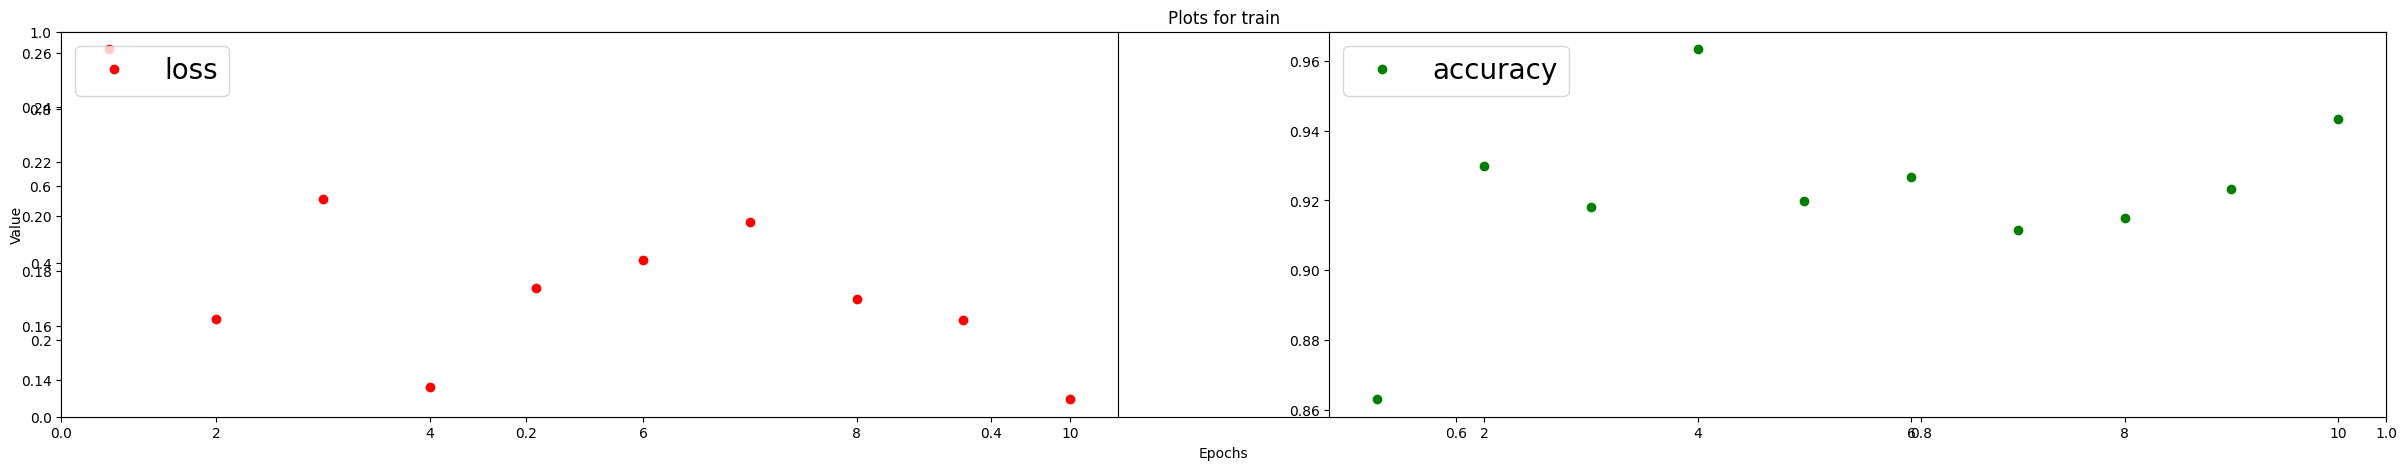

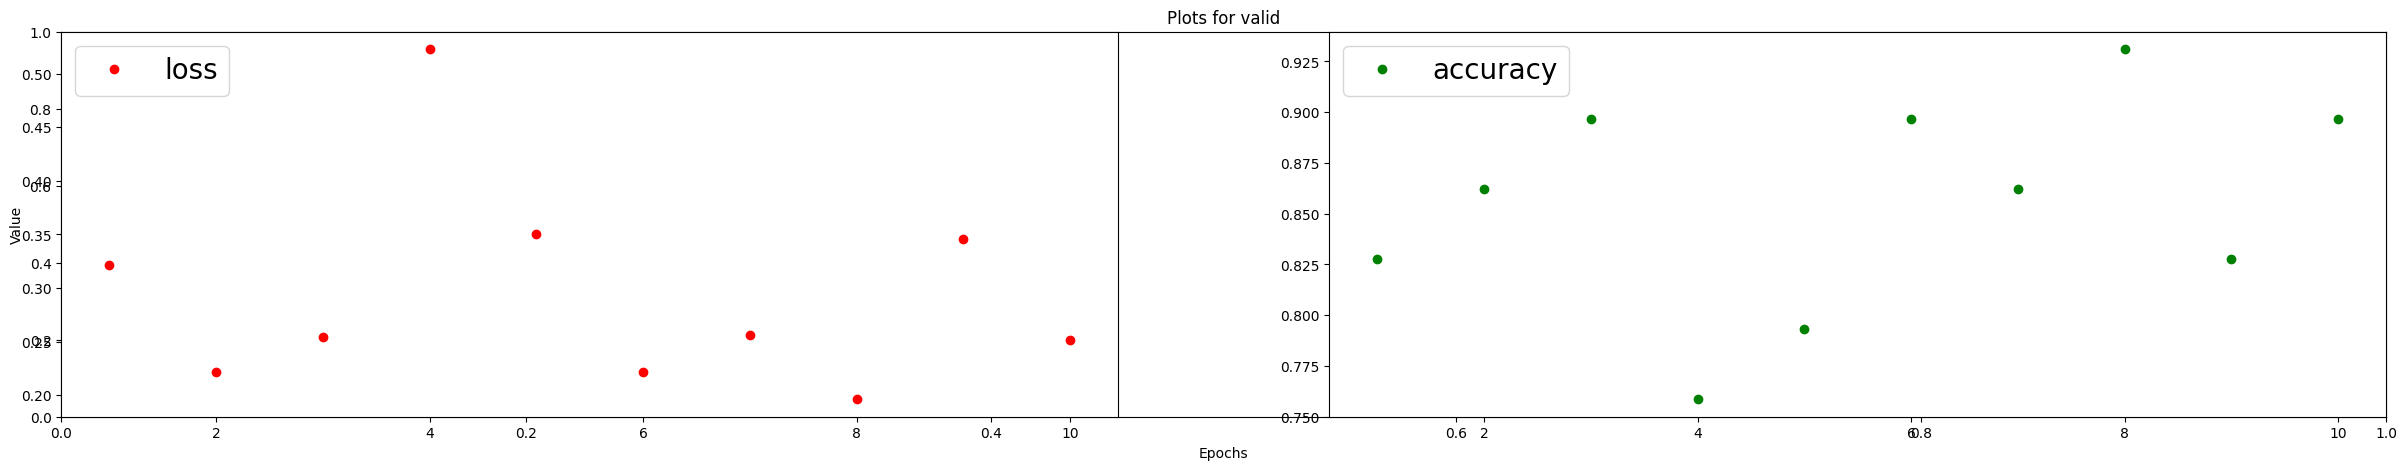

In [15]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50
Epoch : 1, train accuracy : 0.9196969270706177, train loss : 0.20535315573215485
Epoch : 1, val_accuracy : 0.8275862336158752, val_loss : 0.3767735958099365
Epoch : 2, train accuracy : 0.9466666579246521, train loss : 0.12969928979873657
Epoch : 2, val_accuracy : 0.8620689511299133, val_loss : 0.28884848952293396
Epoch : 3, train accuracy : 0.9333333373069763, train loss : 0.13668110966682434
Epoch : 3, val_accuracy : 0.8965517282485962, val_loss : 0.20561259984970093
Epoch : 4, train accuracy : 0.9196969866752625, train loss : 0.18767830729484558
Epoch : 4, val_accuracy : 0.7931034564971924, val_loss : 0.3595581650733948
Epoch : 5, train accuracy : 0.9096969366073608, train loss : 0.16971836984157562
Epoch : 5, val_accuracy : 0.8620689511299133, val_loss : 0.15192224085330963
Epoch : 6, train accuracy : 0.9599999785423279, train loss : 0.1136532574892044
Epoch : 6, val_accuracy : 0.9655172228813171, val_loss : 0.1265089064836502
Epoch : 7, train a

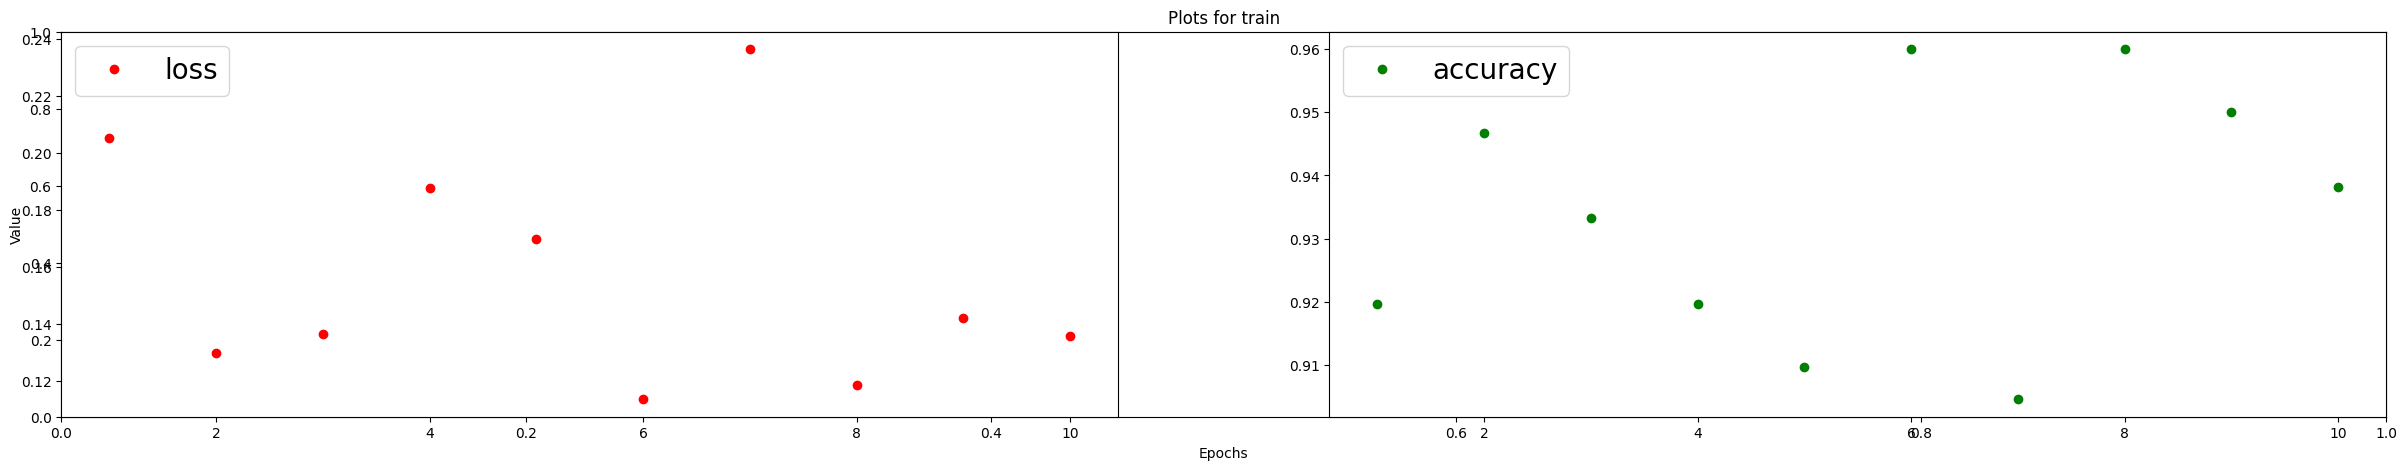

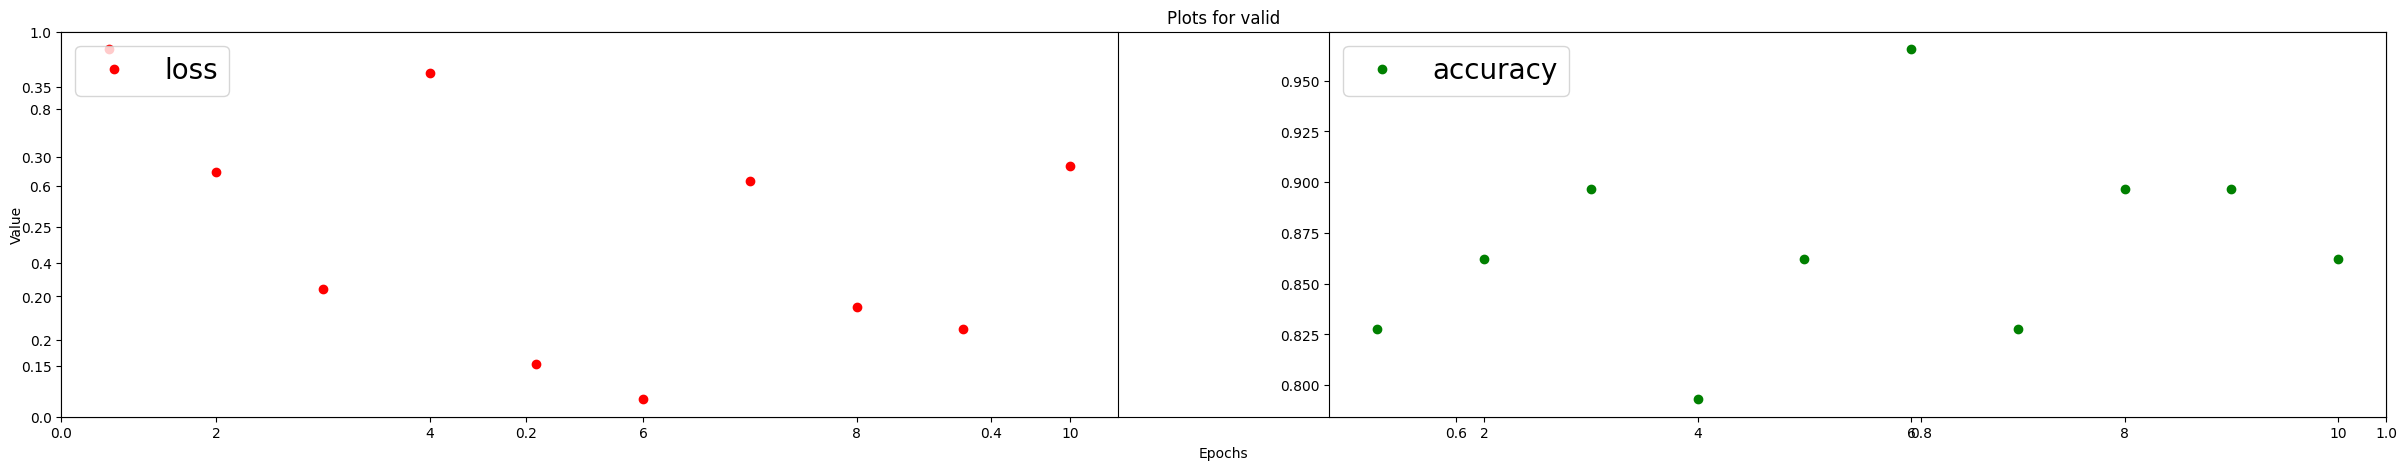

In [16]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9215151071548462, train loss : 0.16707059741020203
Epoch : 1, val_accuracy : 0.8620689511299133, val_loss : 0.1781693398952484
Epoch : 2, train accuracy : 0.9381818771362305, train loss : 0.13217251002788544
Epoch : 2, val_accuracy : 0.8275862336158752, val_loss : 0.47204113006591797
Epoch : 3, train accuracy : 0.899696946144104, train loss : 0.19421084225177765
Epoch : 3, val_accuracy : 0.8275862336158752, val_loss : 0.3180450201034546
Epoch : 4, train accuracy : 0.9348485469818115, train loss : 0.13916368782520294
Epoch : 4, val_accuracy : 0.9655172228813171, val_loss : 0.11688581854104996
Epoch : 5, train accuracy : 0.9633333683013916, train loss : 0.10625024139881134
Epoch : 5, val_accuracy : 0.8620689511299133, val_loss : 0.2868388891220093
Epoch : 6, train accuracy : 0.9181817770004272, train loss : 0.14944122731685638
Epoch : 6, val_accuracy : 0.7931034564971924, val_loss : 0.42634811997413635
Epoch : 7, train a

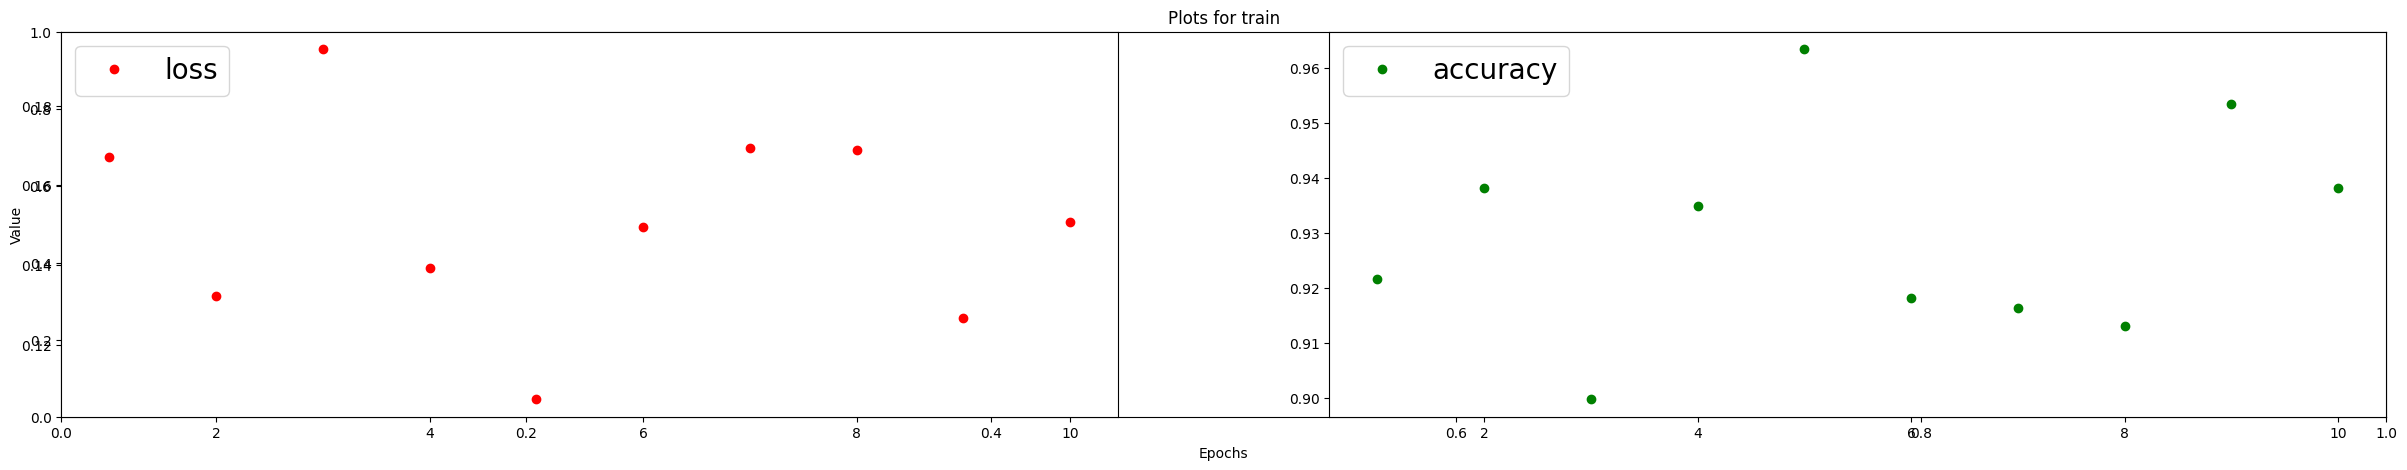

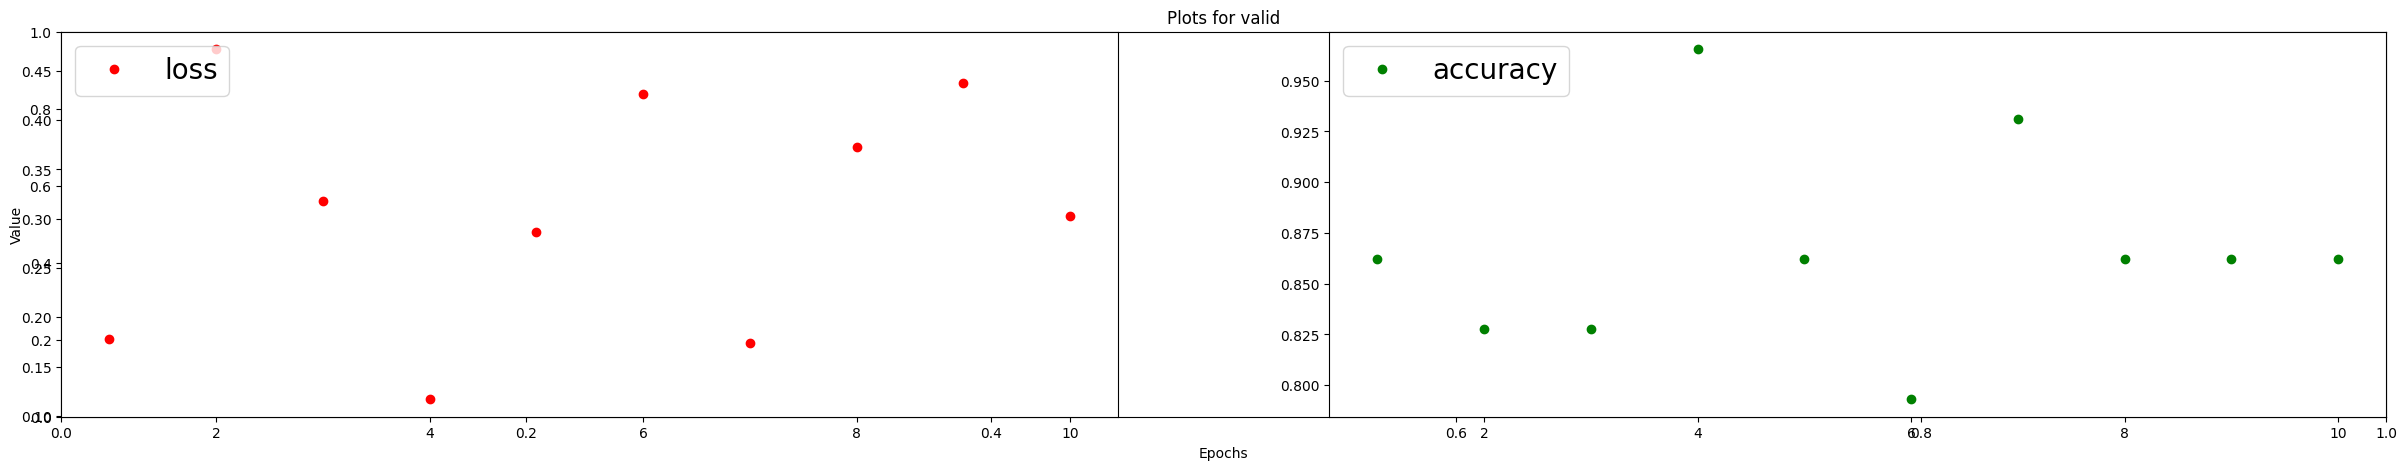

In [17]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [18]:
leopard_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        leopard_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],leopard_probs))
prob = list(map(lambda x: x[1],leopard_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

id     label
0    507  0.366754
1    311  0.000500
2    492  0.045792
3    314  0.011307
4    415  0.083781
..   ...       ...
422  542  0.000238
423  216  0.061156
424  286  0.123130
425  402  0.168082
426  215  0.000222

[427 rows x 2 columns]

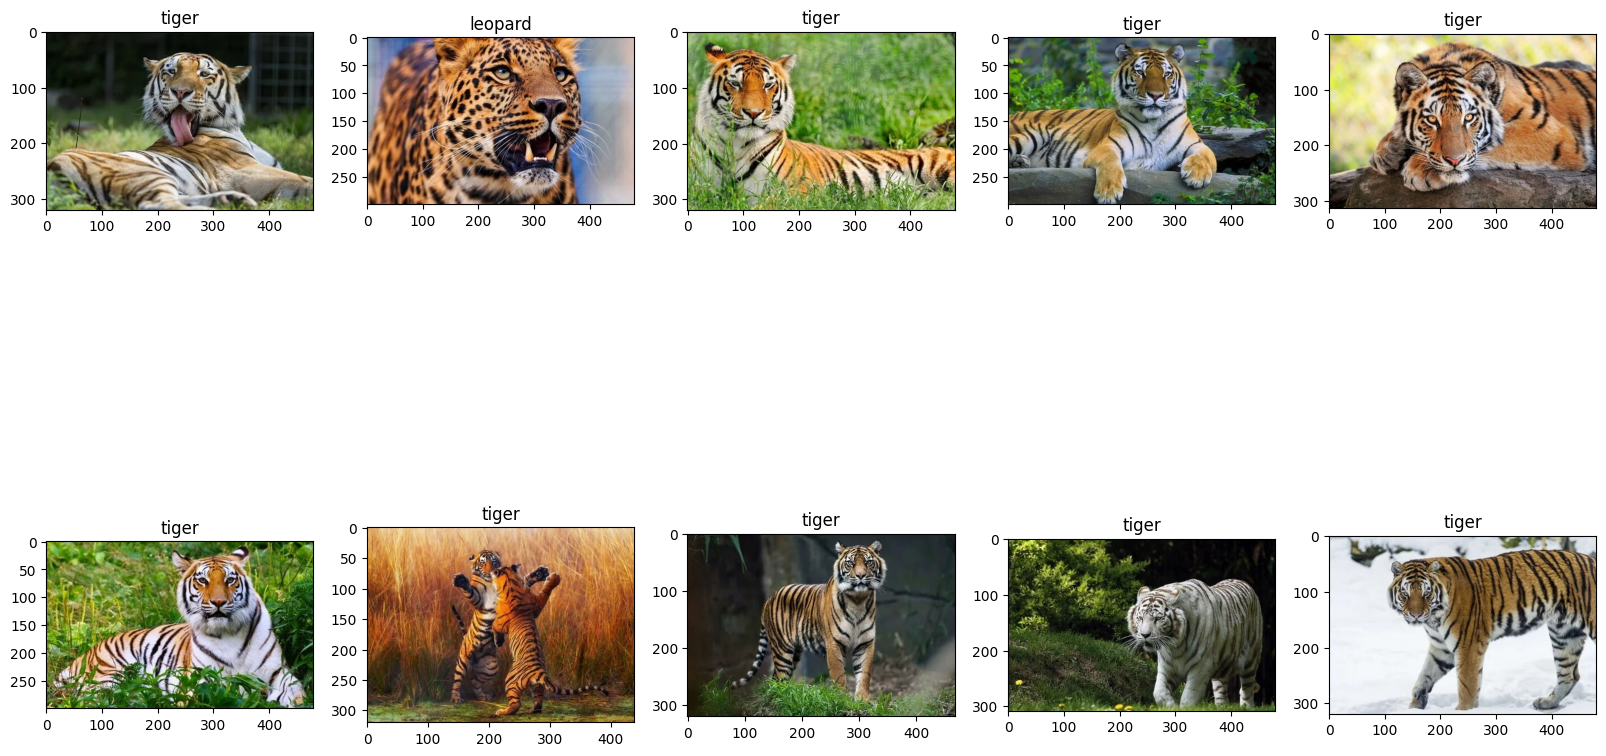

In [19]:
#Evaluate the quality of the model on a test sample
class_ = {0: 'tiger', 1: 'leopard'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)

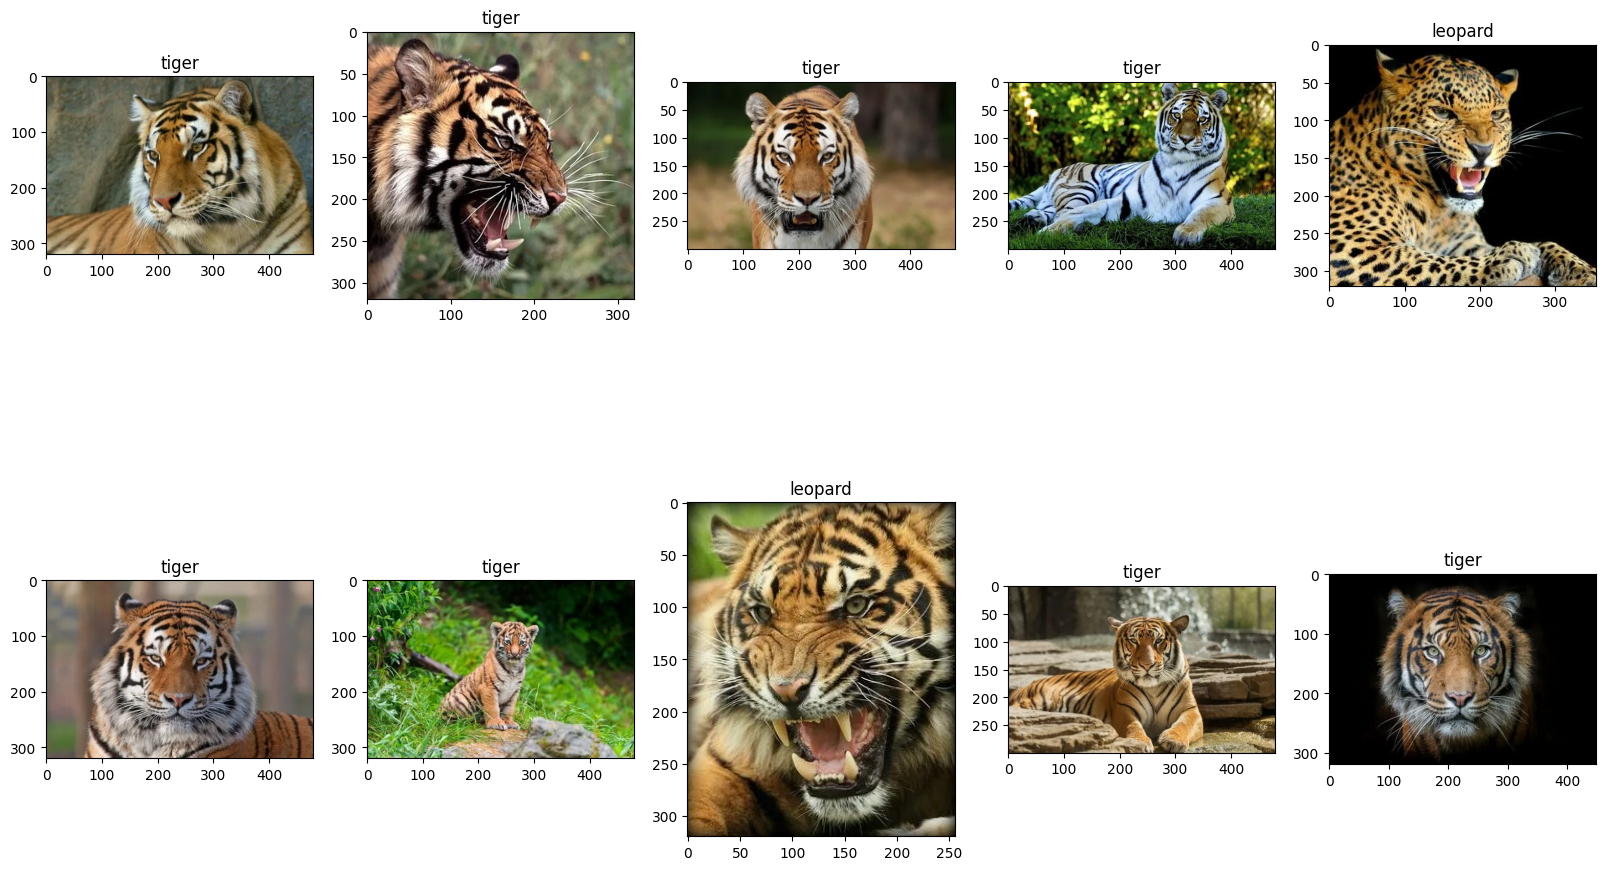

In [20]:
#Save the trained model
torch.save(model.state_dict(), 'ConvNetModel.pth')

loaded_model = ConvNet().to(device)
loaded_model.load_state_dict(torch.load('ConvNetModel.pth'))
loaded_model.eval()

tiger_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tiger_probs += list(zip(labels, preds_list))

idx = list(map(lambda x: x[0],tiger_probs))
prob = list(map(lambda x: x[1],tiger_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'tiger', 1: 'leopard'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)